In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import os 
import sys
import seaborn as sns
from google.colab import drive

warnings.filterwarnings('ignore')
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'USG2_data'
assert FOLDERNAME is not None, "[!] Enter the foldername."
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

path = '/content/drive/MyDrive/USG2_data'

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/USG2_data/train_data"
data_list = []

for i in tqdm(range(1, 3547)):
    file_name = "train_{:04d}.npy".format(i)  # 파일 이름 포맷 지정
    file_path = os.path.join(data_dir, file_name)
    data = np.load(file_path)
    data_list.append(data)

    #넘파이 데이터 파일을 읽어와 리스트에 추가하는 작업 진행, tqdm 라이브러리를 활용해 반복문의 진행 상태를 시각화하므로 실행시간이 오래걸리는 작업일 경우에도 진행상황을 알 수 있다.(퍼센티지)

100%|██████████| 3546/3546 [17:13<00:00,  3.43it/s]


In [ ]:
train_data_dir = "/content/drive/MyDrive/USG2_data/train_data"
train_data_list = []
for i in tqdm(range(1, 3547)):
    file_name = "train_{:04d}.npy".format(i)
    file_path = os.path.join(train_data_dir, file_name)
    data = np.load(file_path)
    train_data_list.append(data)

# load train label
train_label_path = '/content/drive/MyDrive/USG2_data/train_label.csv'
train_label_df = pd.read_csv(train_label_path)
train_label_arr = np.array(train_label_df)[:, 1]

# plot label distribution
unique, counts = np.unique(train_label_arr, return_counts=True)
percentages = [f'{count / len(train_label_arr) * 100:.2f}%' for count in counts]

fig, ax = plt.subplots()
colors = sns.color_palette('bright', len(unique))
ax.bar(unique, counts, color=colors)
ax.set_title('Label Distribution')
ax.set_xticks(unique)
ax.set_xticklabels(unique)
ax.set_xlabel('Label')
ax.set_ylabel('Count')

for i, percentage in enumerate(percentages):
    ax.text(unique[i], counts[i], percentage, ha='center', va='bottom')

plt.show()

#각 0과1 레이블이 얼마나 출현하는지 출연한 횟수를 시각화함.

100%|██████████| 3546/3546 [00:06<00:00, 552.70it/s]


TypeError: ignored

<Figure size 640x480 with 1 Axes>

In [ ]:
# split train data by label
train_abnormal = [train_data_list[i] for i, label in enumerate(train_label_arr) if label == 1]
train_normal = [train_data_list[i] for i, label in enumerate(train_label_arr) if label == 0]
train_label_abnormal = [label for label in train_label_arr if label == 1]
train_label_normal = [label for label in train_label_arr if label == 0]

def windowing(data_list, window_size, num_windows):
    data_len = len(data_list[0])
    stride = int((data_len - window_size) / (num_windows - 1))
    result = []
    for data in data_list:
        for i in range(num_windows):
            start = i * stride
            window = data[start:start+window_size]
            result.append(window)
    return np.array(result)

window_size = 10000
num_windows = 25000
normal_data = windowing(train_normal, window_size, int(num_windows / len(train_normal)))
print(f"Windowed data shape: {normal_data.shape}") 
real_num_windows_normal = len(normal_data)

'''
train_abnormal 리스트는 레이블이 1인 데이터, train_normal 리스트는 레이블이 0인 데이터를 각각 저장합니다. 
train_label_abnormal 리스트와 train_label_normal 리스트는 각각 레이블이 1인 데이터의 레이블과 레이블이 0인 데이터의 레이블을 저장합니다.

레이블이 0인 데이터를 윈도잉하여 normal_data 배열에 저장하고 크기를 출력함.
'''

Windowed data shape: (23200, 10000)


'\ntrain_abnormal 리스트는 레이블이 1인 데이터, train_normal 리스트는 레이블이 0인 데이터를 각각 저장합니다. \ntrain_label_abnormal 리스트와 train_label_normal 리스트는 각각 레이블이 1인 데이터의 레이블과 레이블이 0인 데이터의 레이블을 저장합니다.\n\n레이블이 0인 데이터를 윈도잉하여 normal_data 배열에 저장하고 크기를 출력함.\n'

In [ ]:
window_size = 10000
num_windows = 25000
anomaly_data = windowing(train_abnormal, window_size, int(num_windows / len(train_abnormal)))
print(f"Windowed data shape: {anomaly_data.shape}") 
real_num_windows_anomaly = len(anomaly_data)

Windowed data shape: (24548, 10000)


In [ ]:
import random
normal_labels = np.zeros(real_num_windows_normal)
anomaly_labels = np.ones(real_num_windows_anomaly)

train_normal_ds = tf.data.Dataset.from_tensor_slices((normal_data, normal_labels))
train_anomaly_ds = tf.data.Dataset.from_tensor_slices((anomaly_data, anomaly_labels))

batch_size = 64
buffer_size = real_num_windows_normal+real_num_windows_anomaly + 1

dataset = train_normal_ds.concatenate(train_anomaly_ds).shuffle(buffer_size=buffer_size, seed=1234, reshuffle_each_iteration=False).batch(batch_size).prefetch(1)

'''
normal_data와 normal_labels 배열을 합쳐 train_normal_ds 데이터셋을 생성하고, 
anomaly_data와 anomaly_labels 배열을 합쳐 train_anomaly_ds 데이터셋을 생성합니다.
dataset 변수에는 학습에 사용될 정상 데이터와 이상 데이터가 섞인 데이터셋이 저장됩니다.
'''


'\nnormal_data와 normal_labels 배열을 합쳐 train_normal_ds 데이터셋을 생성하고, \nanomaly_data와 anomaly_labels 배열을 합쳐 train_anomaly_ds 데이터셋을 생성합니다.\ndataset 변수에는 학습에 사용될 정상 데이터와 이상 데이터가 섞인 데이터셋이 저장됩니다.\n'

In [ ]:
(real_num_windows_normal+real_num_windows_anomaly)//batch_size

'''
모든 윈도우의 수를 의미하고 이 수를 배치 사이즈로 나누면 전체 데이터셋을 통과하는데 필요한 배치의 수가 계산됩니다.
즉, 전체 데이터셋을 모두 처리하기 위해 필요한 배치의 수를 반환하는 코드입니다.
'''

'\n모든 윈도우의 수를 의미하고 이 수를 배치 사이즈로 나누면 전체 데이터셋을 통과하는데 필요한 배치의 수가 계산됩니다.\n즉, 전체 데이터셋을 모두 처리하기 위해 필요한 배치의 수를 반환하는 코드입니다.\n'

In [ ]:
valid_dataset = dataset.take(246)
train_dataset = dataset.skip(246)
train_dataset = dataset.take(500)

'''
학습과 검증 데이터셋으로 나누는 코드로 앞에서 246개를 검증 데이터셋으로 이를 제외한 나머지를 학습 데이터셋으로 지정
학습데이터셋에서 앞에서 500개를 선택해 
'''

'\n학습과 검증 데이터셋으로 나누는 코드로 앞에서 246개를 검증 데이터셋으로 이를 제외한 나머지를 학습 데이터셋으로 지정\n학습데이터셋에서 앞에서 500개를 선택해 \n'

In [ ]:
train_dataset.__len__().numpy()

500

In [ ]:
def tf_stft(series_t):
  spectro = tf.signal.stft(series_t, frame_length =256 , frame_step = 64)
  return spectro
#시계열 데이터를 stft 스펙트로그램으로 변환

def tf_reshape_stft(series, label):
  series_t = tf.transpose(series)
  spectros = tf.expand_dims(tf_stft(series_t), axis=-1)
  spectros = tf.abs(spectros)
  return spectros, label
stft_train_dataset = train_dataset.unbatch().map(tf_reshape_stft).batch(64)
stft_valid_dataset = valid_dataset.unbatch().map(tf_reshape_stft).batch(64)
#TensorFlow를 사용하여 시계열 데이터에 대한 STFT 전처리를 수행하여 데이터셋을 구성하는 과정

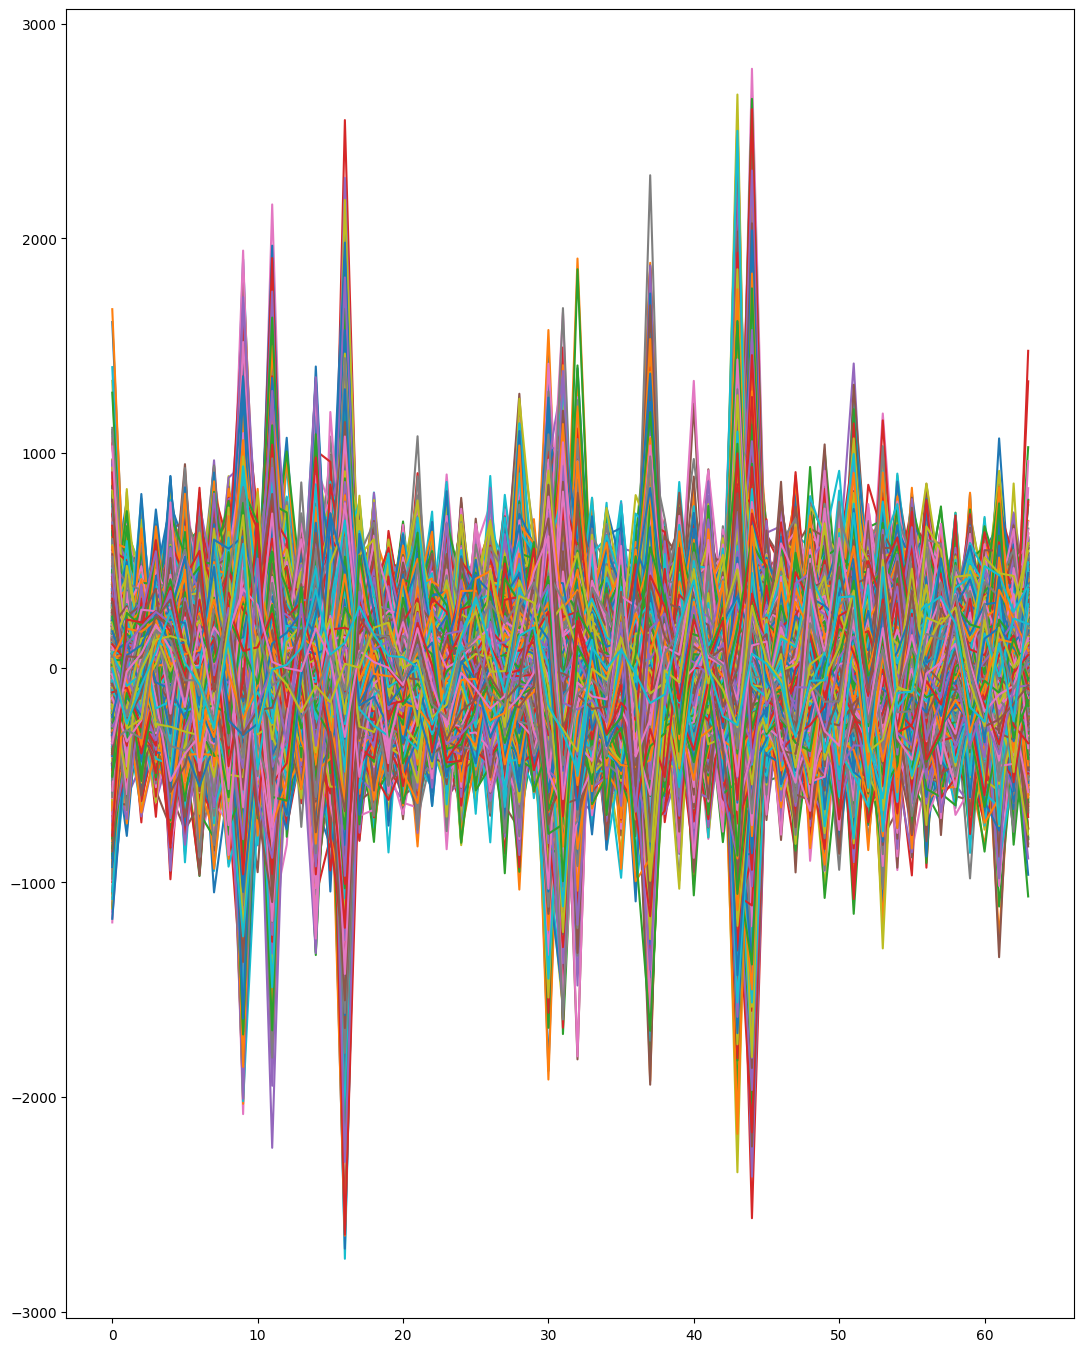

In [ ]:
for ser, lable in dataset.take(1):
  fig, axes = plt.subplots(1, figsize=(13, 17))
  timescale = np.arange(ser.shape[0])
  plt.plot(timescale, ser[:,:].numpy())
  plt.show()

  #첫번째 배치를 시각화한 것, 데이터셋을 확인하는 용도

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

  #스펙트로그램을 시각화하는 함수

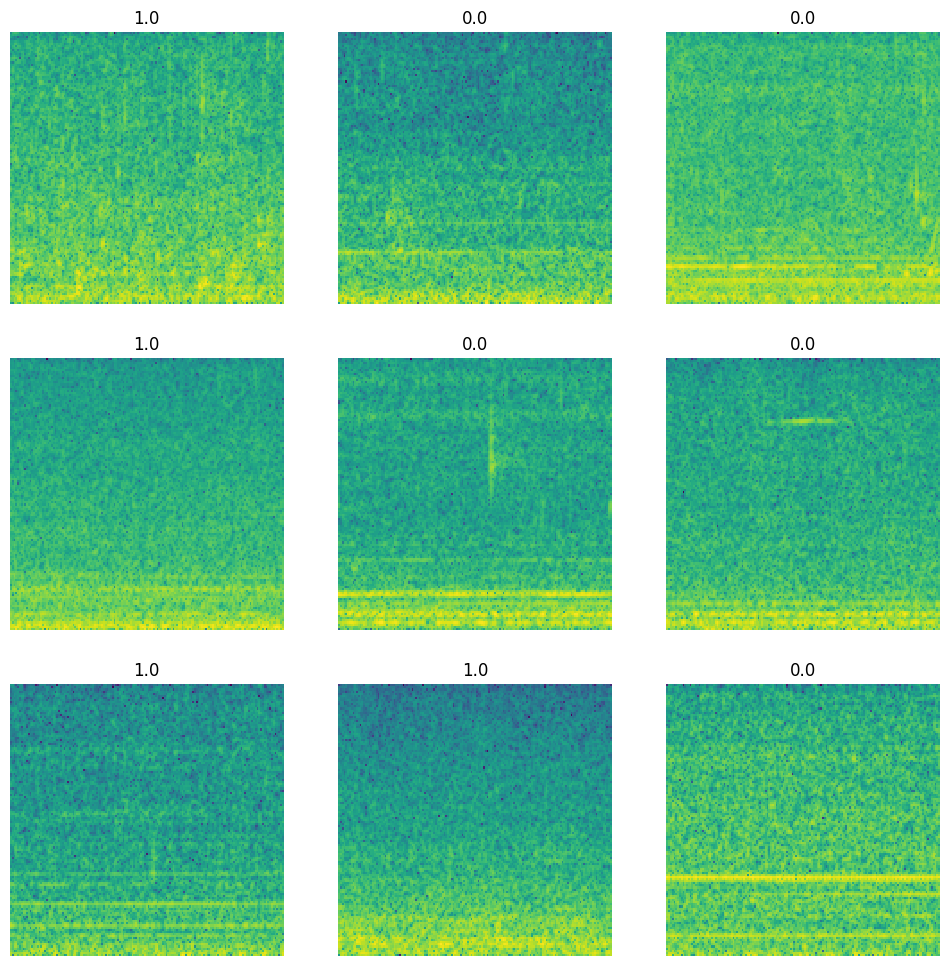

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i, (spectrogram, label_id) in enumerate(stft_train_dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram[:,:].numpy()), ax)
  ax.set_title(label_id.numpy())
  ax.axis('off')

plt.show()

#스펙트로그램이 어떻게 생겼는지 시각화해서 보여줌

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

In [ ]:
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import math
kernel_size = [3,3,5,3,5]
num_repeat = [1,1,1,2,2]
output_filters = [16,24,40,80,120]
strides = [1,2,2,2,1]
MBConvBlock_1_True  =  [True,False,False,False,False]
se_ratio = 4
expand_ratio = 6
width_coefficient = 1.2
depth_coefficient = 1.4
#default_resolution = 224
input_channels = 3
depth_divisor= 8 
dropout_rate = 0.3
drop_connect_rate = 0.2
def round_filters(filters, width_coefficient, depth_divisor):
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)
def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(depth_coefficient * repeats))
class DropConnect(tf.keras.layers.Layer):
    def __init__(self, drop_connect_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, training):
        def _drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += K.random_uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(_drop_connect, inputs, training=training)
def SEBlock(filters,reduced_filters):
    def _block(inputs):
        x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        x = tf.keras.layers.Reshape((1,1,x.shape[1]))(x)
        x = tf.keras.layers.Conv2D(reduced_filters, 1, 1)(x)
        x = tfa.activations.mish(x)
        x = tf.keras.layers.Conv2D(filters, 1, 1)(x)
        x = tf.keras.layers.Activation('sigmoid')(x)
        x = tf.keras.layers.Multiply()([x, inputs])
        return x
    return _block
def MBConvBlock(x,kernel_size, strides,drop_connect_rate,output_channels,MBConvBlock_1_True=False):
    output_channels = round_filters(output_channels,width_coefficient,depth_divisor)
    if MBConvBlock_1_True:
        block = tf.keras.layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(x)
        block = tf.keras.layers.BatchNormalization()(block)
        block = tfa.activations.mish(block)
        block = SEBlock(x.shape[3],x.shape[3]/se_ratio)(block)
        block = tf.keras.layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
        block = tf.keras.layers.BatchNormalization()(block)
        return block

    channels = x.shape[3]
    expand_channels = channels * expand_ratio
    block = tf.keras.layers.Conv2D(expand_channels, (1,1), padding='same', use_bias=False)(x)
    block = tf.keras.layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = tf.keras.layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(block)
    block = tf.keras.layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = SEBlock(expand_channels,channels/se_ratio)(block)
    block = tf.keras.layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
    block = tf.keras.layers.BatchNormalization()(block)
    if x.shape[3] == output_channels:
        block = DropConnect(drop_connect_rate)(block)
        block = tf.keras.layers.Add()([block, x])
    return block
def EffNet(num_classes):
    x_input = tf.keras.layers.Input(shape=(153,129,1))    
    x = tf.keras.layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), (3,3), 2,padding='same', use_bias=False)(x_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    num_blocks_total = sum(num_repeat)
    block_num = 0
    for i in range(len(kernel_size)):
        round_num_repeat = round_repeats(num_repeat[i], depth_coefficient)
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = MBConvBlock(x,kernel_size[i],strides[i],drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
        block_num += 1
        if round_num_repeat > 1:
            for bidx in range(round_num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                x = MBConvBlock(x,kernel_size[i],1,drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
                block_num += 1
    x = tf.keras.layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 1,padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = 2)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(num_classes,activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x)
    return model


net = EffNet(1)
net.summary()

net.compile(optimizer='adam',
              loss='binary_crossentropy',run_eagerly=True,
              metrics=['accuracy']) # ANY CALLBACKS?


history = net.fit(stft_train_dataset, epochs = 10, shuffle = True, validation_data = stft_valid_dataset, callbacks = callbacks)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.8 MB/s eta 0:00:00
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 153, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 77, 65, 40)   360         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 77, 65, 40)  160         ['conv2d[0][0]']                 
 alization)  

    448/Unknown - 282s 550ms/step - loss: 0.2071 - accuracy: 0.9151

KeyboardInterrupt: ignored

In [ ]:
#net.save_weights("/content/drive/MyDrive/USG2_data/STFT_efficientnet_1.h5")

In [ ]:
net.load_weights("/content/drive/MyDrive/USG2_data/STFT_efficientnet_1.h5")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model

# 모델 구조 시각화
plot_model(net, show_shapes=True, to_file='EfficientNetB0.png')

# TensorBoard를 사용하여 레이어 시각화
log_dir = "logs/effnet_b0"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 모델 학습
net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
net.fit(x_train, y_train, epochs=10, batch_size=32, callbacks=[tensorboard_callback])

# TensorBoard 실행
%load_ext tensorboard
%tensorboard --logdir logs/effnet_b0


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(net, to_file='model_shapes.png', show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
net.compile(optimizer='adam',
              loss='binary_crossentropy',run_eagerly=True,
              metrics=['accuracy']) # ANY CALLBACKS?


history = net.fit(stft_train_dataset, epochs = 20, shuffle = True, validation_data = stft_valid_dataset, callbacks = callbacks)

Epoch 1/20
500/500 [==============================] - 278s 518ms/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.0132 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - 262s 524ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0647 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - 259s 518ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.0026 - val_accuracy: 0.9990 - lr: 5.0000e-04
Epoch 4/20
500/500 [==============================] - 258s 516ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0688 - val_accuracy: 0.9800 - lr: 5.0000e-04
Epoch 5/20
500/500 [==============================] - 258s 516ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 0.9992 - lr: 2.5000e-04
Epoch 6/20
500/500 [==============================] - 258s 516ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 2.4666e-04 - val_accuracy: 0.9999 - lr: 2.5000e-04
Epoch 7/20
500/500 [======

In [ ]:
net.save_weights("/content/drive/MyDrive/USG2_data/STFT_efficientnet_2.h5")

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=2, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=7, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]
net.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 6.2500e-05),
              loss='binary_crossentropy',run_eagerly=True,
              metrics=['accuracy'])
history = net.fit(stft_train_dataset, epochs = 30, shuffle = True, validation_data = stft_valid_dataset, callbacks = callbacks)

Epoch 1/30
500/500 [==============================] - 355s 660ms/step - loss: 9.7619e-04 - accuracy: 0.9998 - val_loss: 2.2064e-04 - val_accuracy: 0.9999 - lr: 6.2500e-05
Epoch 2/30
 70/500 [===>..........................] - ETA: 51:32 - loss: 3.7619e-04 - accuracy: 1.0000

In [ ]:
int(num_windows / 1115)

22

In [ ]:
test_data_dir = "/content/drive/MyDrive/USG2_data/test_data"
num_windows = 1115*8
test_data_list = []
windowed_data_lists = []
for i in tqdm(range(1, 1116)):
    file_name = "test_{:04d}.npy".format(i)  
    file_path = os.path.join(test_data_dir, file_name)
    test_data = np.load(file_path)
    test_data_list.append(test_data)



100%|██████████| 1115/1115 [05:47<00:00,  3.21it/s]


In [ ]:
test_data = windowing(test_data_list, window_size, int(num_windows / 1115))
print(f"Windowed data shape: {test_data.shape}") 
real_num_windows_test = len(test_data)
empty_label = None
Test_Set = tf.data.Dataset.from_tensor_slices((test_data ,empty_label))
Test_Set = Test_Set.batch(batch_size)
Test_Set_stft = Test_Set.unbatch().map(tf_reshape_stft).batch(64)

Windowed data shape: (8920, 10000)


In [ ]:
y_pred = net.predict(Test_Set_stft)
# 예측 수행

140/140 [==============================] - 17s 119ms/step


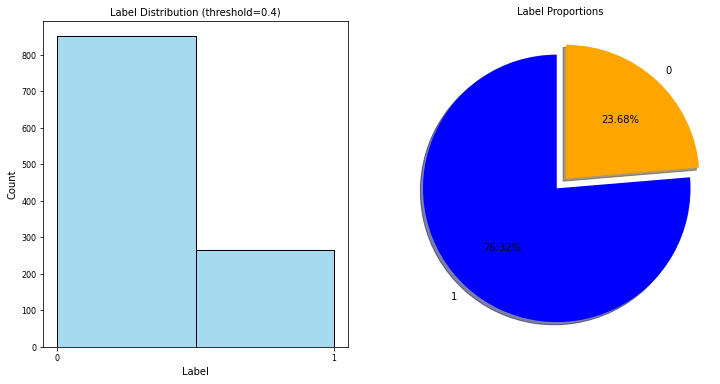

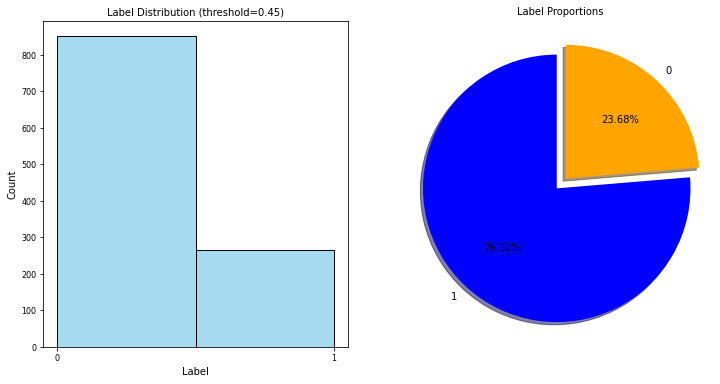

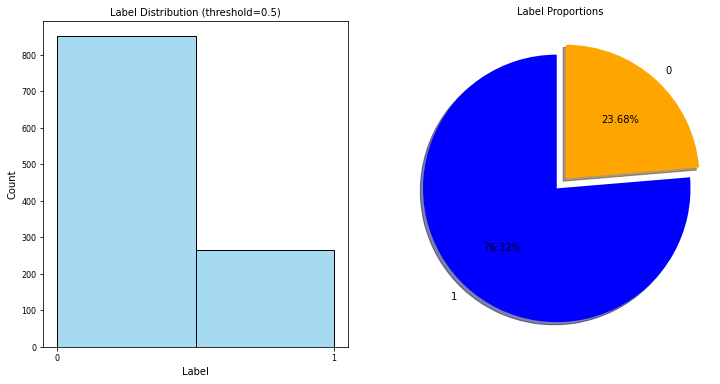

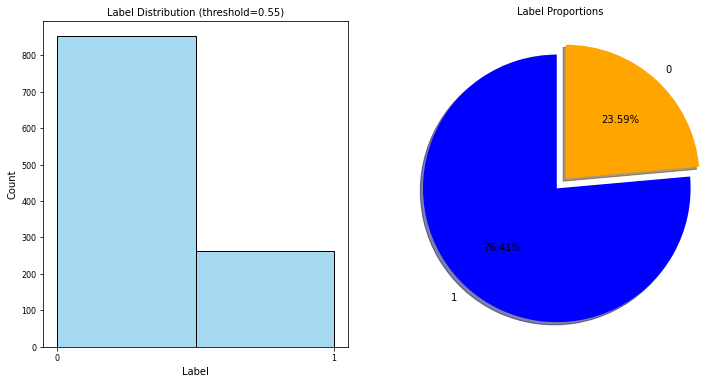

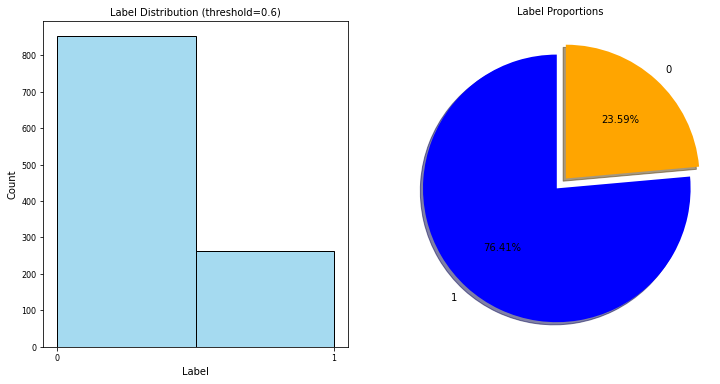

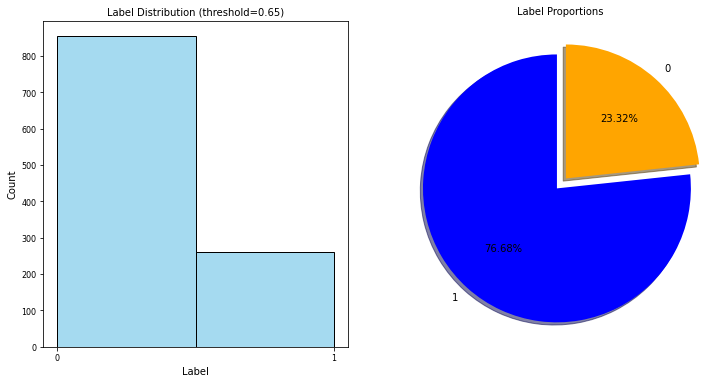

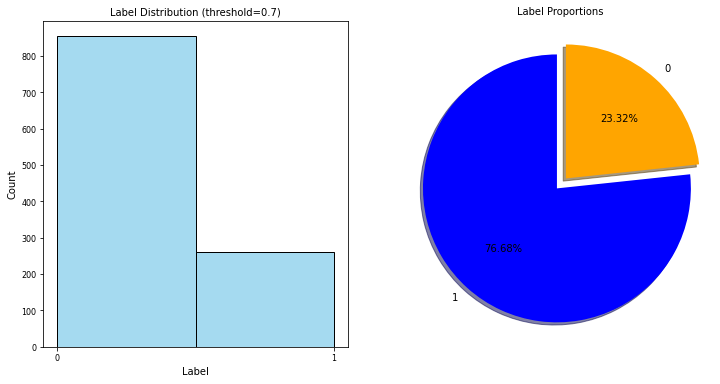

In [ ]:
def binary_predictions(y_pred, threshold=0.5):
    return (y_pred >= threshold).astype(int)

def plot_label_distribution(y_pred, title, xlabel='Label', ylabel='Count', 
                             xticklabels=None, fontsize=10, palette=['blue','orange']):
    # Convert y_pred to a pandas Series
    y_pred_series = pd.Series(y_pred.flatten())
    # Histogram
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(x=y_pred_series, color='skyblue', bins=2, ax=ax[0])
    ax[0].set_xlabel(xlabel, fontsize=fontsize)
    ax[0].set_ylabel(ylabel, fontsize=fontsize)
    ax[0].set_title(title, fontsize=fontsize)
    ax[0].set_xticks([1,0])
    ax[0].set_xticklabels(['1','0'])
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize-2)

    # Pie chart
    labels = ['1', '0']
    sizes = y_pred_series.value_counts(normalize=True)
    colors = palette
    explode = (0, 0.1)
    ax[1].pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.2f%%', shadow=True, startangle=90)
    ax[1].axis('equal') 
    ax[1].set_title("Label Proportions", fontsize=fontsize)

    plt.show()

pred_thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7]
test_labels = []

for threshold in pred_thresholds:
    label = binary_predictions(np.array([sum(y_pred[8*i:8*i+8]) for i in range(len(test_data_list))])/8.0, threshold=threshold)
    test_labels.append(label)
    plot_label_distribution(label, title=f"Label Distribution (threshold={threshold})")


In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/USG2_data/answer_sample.csv')
sub.iloc[:,1] = test_labels[4]
sub.to_csv("/content/drive/MyDrive/USG2_data/STFT_Efficientnet_06.csv",index = False)